In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from scipy import stats

from wavespectra import read_ww3, read_swan, read_ndbc, read_netcdf #don't need all of these
from wavespectra.input.swan import read_swans

DATA_DIRECTORY = '/vortexfs1/home/csherwood/proj/NOPP/buoy_data/'
DATA_FILENAME = 'hurricane_ian_spotter_data_v1.pickle'
MODEL_DIRECTORY = '/vortexfs1/share/usgs-share/Projects/Ian2022/ian10/drifters/'

# This runs my local file with the new ndbc buoy input
# Might not need this if the wavespectra installation is up to date.
%run -i /vortexfs1/home/csherwood/src/wavespectra/wavespectra/input/ndbc.py

In [2]:
# These are the GOM buoys with data for Ian
buoys = ['42039','42098', '42099']
# pick one for testing
buoy = buoys[0]

In [3]:
# Process one buoy as a test
fn = "{}.spc2d".format(buoy)
dsm = read_swan(MODEL_DIRECTORY+fn)
# get start/end times
stime = dsm.time[0].values
etime = dsm.time[-1].values
print(stime,' to ',etime)
dtmod = np.squeeze( dsm.time.values )
hsmod = np.squeeze( dsm.efth.spec.hs().values )

# assume the file has all years, thus w9999 instead of w2022
# read the NDBC buoy observations for the same time slice
url ='https://dods.ndbc.noaa.gov/thredds/dodsC/data/swden/' + str(buoy) + '/' + str(buoy) + 'w9999' + '.nc'
print(url)
dso = read_ndbc(url, chunks={}, always_2d=True).sel(time=slice(stime, etime))
dtobs = np.squeeze(dso.time)
hsobs = np.squeeze(dso.efth.spec.hs().values)

# interpolate modeled to times of observation (in case some are missing)
dsmi = dsm.interp(time=dso.time, method='nearest')
hsmodi = np.squeeze( dsmi.efth.spec.hs().values )
rmse = np.sqrt( np.nanmean( (hsobs - hsmodi)**2) )
print(rmse)

2022-09-26T00:00:00.000000000  to  2022-10-02T00:00:00.000000000
https://dods.ndbc.noaa.gov/thredds/dodsC/data/swden/42039/42039w9999.nc
0.2072119026495582


2022-09-26T00:00:00.000000000  to  2022-10-02T00:00:00.000000000
https://dods.ndbc.noaa.gov/thredds/dodsC/data/swden/42039/42039w9999.nc
0.2072119026495582
2022-09-26T00:00:00.000000000  to  2022-10-02T00:00:00.000000000
https://dods.ndbc.noaa.gov/thredds/dodsC/data/swden/42098/42098w9999.nc
0.38824527990819846
2022-09-26T00:00:00.000000000  to  2022-10-02T00:00:00.000000000
https://dods.ndbc.noaa.gov/thredds/dodsC/data/swden/42099/42099w9999.nc
0.4008667920533488


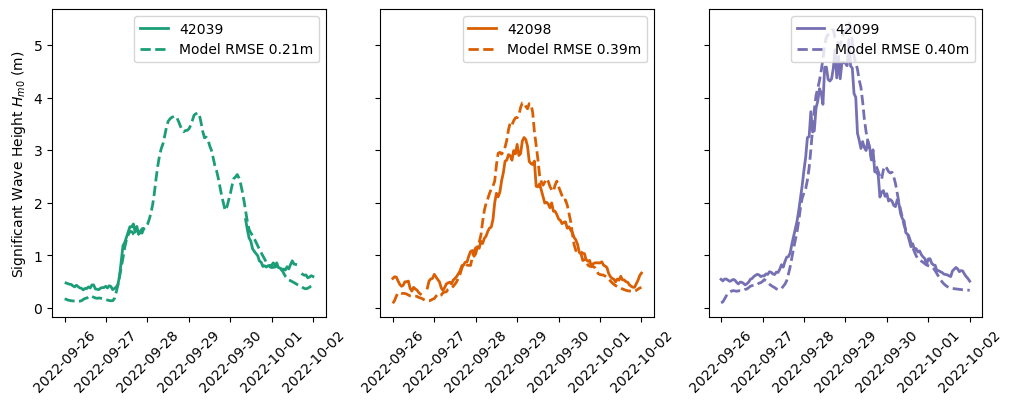

In [4]:
# Time-series plots - process all of the buoys
wcolors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02'] # dark2 qualititative from colorbrewer
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(12,4))
ax = np.ravel(ax)

for i, buoy in enumerate( buoys ):
    # read the model output
    fn = "{}.spc2d".format(buoy)
    dsm = read_swan(MODEL_DIRECTORY+fn)
    # get start/end times
    stime = dsm.time[0].values
    etime = dsm.time[-1].values
    print(stime,' to ',etime)
    dtmod = np.squeeze( dsm.time.values )
    hsmod = np.squeeze( dsm.efth.spec.hs().values )

    # assume the file has all years
    # read the NDBC buoy observations for the same time slice
    url ='https://dods.ndbc.noaa.gov/thredds/dodsC/data/swden/' + str(buoy) + '/' + str(buoy) + 'w9999' + '.nc'
    print(url)
    dso = read_ndbc(url, chunks={}, always_2d=True).sel(time=slice(stime, etime))
    dtobs = np.squeeze(dso.time)
    hsobs = np.squeeze(dso.efth.spec.hs().values)
    
    # interpolate modeled to times of observation (in case some are missing)
    dsmi = dsm.interp(time=dso.time, method='nearest')
    hsmodi = np.squeeze( dsmi.efth.spec.hs().values )
    rmse = np.sqrt( np.nanmean( (hsobs - hsmodi)**2) )
    
    ts = 'Model RMSE {:.2f}m'.format(rmse)
    print(rmse)

    ax[0].set_ylabel('Significant Wave Height $H_{m0}$ (m)')
    ax[0].tick_params(axis='x', rotation=45)
    ax[1].tick_params(axis='x', rotation=45)
    ax[2].tick_params(axis='x', rotation=45)

    ax[i].plot(dtobs, hsobs,linewidth=2,c=wcolors[i],label=buoy)
    ax[i].plot(dtmod, hsmod,'--',linewidth=2,c=wcolors[i],label=ts)
    ax[i].legend(loc='upper right')

plt.show()
fig.savefig('ndbc_ts_3panel.svg', bbox_inches='tight')


2022-09-26T00:00:00.000000000  to  2022-10-02T00:00:00.000000000
https://dods.ndbc.noaa.gov/thredds/dodsC/data/swden/42039/42039w9999.nc
NaNs in obs: 0; length obs. 86
NaNs in model:  0
NaNs in model: 0; length model. 86
2022-09-26T00:00:00.000000000  to  2022-10-02T00:00:00.000000000
https://dods.ndbc.noaa.gov/thredds/dodsC/data/swden/42098/42098w9999.nc
NaNs in obs: 0; length obs. 142
NaNs in model:  0
NaNs in model: 0; length model. 142
2022-09-26T00:00:00.000000000  to  2022-10-02T00:00:00.000000000
https://dods.ndbc.noaa.gov/thredds/dodsC/data/swden/42099/42099w9999.nc
NaNs in obs: 0; length obs. 145
NaNs in model:  0
NaNs in model: 0; length model. 145


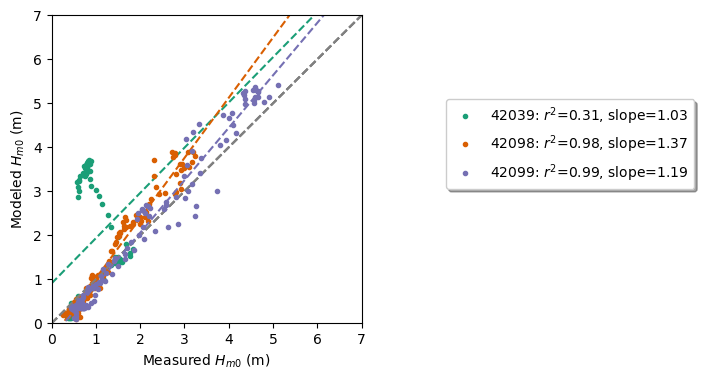

In [5]:
# Scatter plot
fig, ax = plt.subplots(ncols=1, figsize=(4,4))
for i, buoy in enumerate( buoys ):
    # read the model output
    fn = "{}.spc2d".format(buoy)
    dsm = read_swan(MODEL_DIRECTORY+fn)
    # get start/end times
    stime = dsm.time[0].values
    etime = dsm.time[-1].values
    print(stime,' to ',etime)
    dtmod = np.squeeze( dsm.time.values )
    hsmod = np.squeeze( dsm.efth.spec.hs().values )

    # assume the file has all years
    # read the NDBC buoy observations for the same time slice
    url ='https://dods.ndbc.noaa.gov/thredds/dodsC/data/swden/' + str(buoy) + '/' + str(buoy) + 'w9999' + '.nc'
    print(url)
    dso = read_ndbc(url, chunks={}, always_2d=True).sel(time=slice(stime, etime))
    dtobs = np.squeeze(dso.time)
    hsobs = np.squeeze(dso.efth.spec.hs().values)
    hsobs = hsobs[np.where( np.isfinite( hsobs ))]
    print('NaNs in obs: {}; length obs. {}'.format(np.sum(np.isnan(hsobs)),len(hsobs)))
          
    # interpolate modeled to times of observation (in case some are missing)
    dsmi = dsm.interp(time=dso.time, method='nearest')
    hsmodi = np.squeeze( dsmi.efth.spec.hs().values )
    print('NaNs in model: ',np.sum(np.isnan(hsmodi)))
    hsmodi = hsmodi[np.where( np.isfinite( hsobs ))]
    print('NaNs in model: {}; length model. {}'.format(np.sum(np.isnan(hsmodi)),len(hsmodi)))

    gradient, intercept, r_value, p_value, std_err = stats.linregress(hsobs,hsmodi)
    # mn=np.min(hsobs)
    # mx=np.max(hsobs)
    mn=0.
    mx=7.
    x1d=np.linspace(mn,mx,10)
    y1d=gradient*x1d+intercept
    ts = '{}: $r^2$={:.2f}, slope={:.2f}'.format(buoy,r_value,gradient)
    ax.plot([0,7],[0,7],'--',c='gray')
    ax.plot(x1d,y1d,'--',c=wcolors[i])
    ax.plot(hsobs,hsmodi,'.',c=wcolors[i],label=ts)
    # ax.text(x=.95, y=.05, s=ts, fontsize=10, c='tab:blue',transform=ax2.transAxes,\
    #              horizontalalignment='right', verticalalignment='bottom')
    ax.set_ylabel('Modeled $H_{m0}$ (m)')
    ax.set_xlabel('Measured $H_{m0}$ (m)')
    ax.axis([0, 7, 0, 7])
    if(i==2):
        ax.legend(bbox_to_anchor=(1.25, .75),
          ncol=1, fancybox=True, shadow=True)

plt.show()
fig.savefig('multi_ndbc_scatter.svg', bbox_inches='tight')